In [3]:
import drjit as dr
import mitsuba as mi
import numpy as np

from scenes import cornell_box, cornell_box_steady_state
import matplotlib.pyplot as plt
from IPython.display import HTML
from matplotlib.animation import FuncAnimation
import cv2

mi.set_variant('cuda_ad_rgb')

from mitsuba.ad.integrators.common import ADIntegrator
import mitransient as mitr
from mitransient.films.transient_hdr_film import TransientHDRFilm

In [4]:
class GaussianPulse:
    """
    Normalized Gaussian pulse centered at t=0.

    The pulse is defined as:
        p(t) = (1 / (σ √(2π))) × exp(-t² / (2σ²))

    where σ is the standard deviation (width_opl in optical path length units).
    """

    def __init__(self, width_opl: float):
        """
        Initialize the Gaussian pulse.

        Args:
            width_opl: Standard deviation in optical path length units (meters)
        """
        self.width_opl = width_opl
        self.normalization = 1.0 / (self.width_opl * dr.sqrt(2 * dr.pi))

    def eval(self, t: mi.Float) -> mi.Float:
        """
        Evaluate the Gaussian at time offset t.

        Args:
            t: Time offset from pulse center (in OPL units)

        Returns:
            Normalized Gaussian value at t
        """
        return self.normalization * dr.exp(-0.5 * (t / self.width_opl) ** 2)

    def sample(self, xi: mi.Float):
        """
        Sample a time offset from the Gaussian distribution using inverse CDF.

        Args:
            xi: Uniform random value in [0, 1]

        Returns:
            Tuple of (sampled_time, weight) where weight is always 1.0
            for importance sampling
        """
        # TODO: Implement inverse CDF sampling using the inverse error function
        # Hint: For a Gaussian, the inverse CDF is: μ + σ × √2 × erfinv(2ξ - 1)
        # Use dr.erfinv() for the inverse error function
        return self.width_opl * dr.sqrt(2) * dr.erfinv(2 * xi - 1)
    

In [5]:
# Test that the pulse integrates to 1
pulse = GaussianPulse(width_opl=0.05)
t = dr.linspace(mi.Float, -0.5, 0.5, 1000)
dt = 1.0 / 1000
integral = dr.sum(pulse.eval(t)) * dt
print(f"Integral: {integral[0]:.4f} (should be ~1.0)")

# Test sampling
samples = [pulse.sample(dr.opaque(mi.Float, np.random.random()))[0] for _ in range(10000)]
print(f"Sample mean: {np.mean(samples):.4f} (should be ~0.0)")
print(f"Sample std: {np.std(samples):.4f} (should be ~{pulse.width_opl:.4f})")

Integral: 0.9990 (should be ~1.0)
Sample mean: 0.0001 (should be ~0.0)
Sample std: 0.0499 (should be ~0.0500)


In [6]:
def visualize_transient(transient_data, start_opl, bin_width_opl):
    """Create an animation of light propagating through the scene."""
    data = np.array(transient_data)

    # Average RGB channels for visualization
    if data.ndim == 4:
        data = np.mean(data, axis=-1)

    fig, ax = plt.subplots()
    vmax = np.percentile(data, 99)
    im = ax.imshow(data[:, :, 0], cmap='hot', vmin=0, vmax=vmax)

    def update(frame):
        im.set_array(data[:, :, frame])
        opl = start_opl + frame * bin_width_opl
        t_ns = opl / 0.3  # Convert to nanoseconds (c ≈ 0.3 m/ns)
        ax.set_title(f't = {t_ns:.2f} ns')
        return [im]

    anim = FuncAnimation(fig, update, frames=data.shape[2], interval=50, blit=True)
    return anim

def plot_pixel_transient(transient_data, x, y, start_opl, bin_width_opl):
    """Plot temporal response at a single pixel."""
    data = np.array(transient_data)
    response = data[y, x, :]

    times = start_opl + np.arange(len(response)) * bin_width_opl
    times_ns = times / 0.3

    plt.figure()
    plt.plot(times_ns, response)
    plt.xlabel('Time (ns)')
    plt.ylabel('Intensity')
    plt.title(f'Transient at pixel ({x}, {y})')
    plt.show()

In [7]:
class TimeGatedTransientPath(mi.SamplingIntegrator):
    def __init__(self, props=mi.Properties()):
        super().__init__(props)
        self.max_depth = props.get('max_depth', 8)
        self.pulse = GaussianPulse(width_opl=props.get('gaussian_stddev', 0.03))
        self.camera_unwarp = props.get('camera_unwarp', False)
        self.temporal_filter = props.get('temporal_filter', 'box')

    @dr.syntax
    def sample(self, scene, sampler, ray, target_time, medium=None, active=True):
        """
        Sample paths and weight by temporal pulse.

        Args:
            scene: The scene to render
            sampler: Random number generator
            ray: Camera ray
            target_time: The target time (in OPL units) we're rendering for
            medium: Participating medium (optional)
            active: Active ray mask

        Returns:
            (color, valid, aov) tuple
        """
        result = mi.Color3f(0.0)
        throughput = mi.Color3f(1.0)
        ray = mi.Ray3f(ray)
        active = mi.Bool(active)

        # Track total path length (optical path length)
        path_length = mi.Float(0.0)
        depth = mi.UInt32(0)

        while dr.hint(active, max_iterations=self.max_depth, label="Path"):
            si = scene.ray_intersect(ray, active)
            active &= si.is_valid()

            # Accumulate path length
            path_length[active] += si.t

            # Get BSDF and context
            ctx = mi.BSDFContext()
            bsdf = si.bsdf()

            # Emitter contribution (only for directly hit emitters)
            # emitter = si.emitter(scene)
            # emitter_contrib = dr.select(
            #     emitter != None,
            #     emitter.eval(si, active),
            #     mi.Color3f(0.0)
            # )
            # result[active] += throughput * emitter_contrib

            # Sample direct illumination from light sources (NEE)
            ds, emitter_weight = scene.sample_emitter_direction(
                si, sampler.next_2d(), True, active
            )

            active_light = active & (ds.pdf > 0)

            # Remove the if dr.any() check - just use masking
            # Evaluate BSDF
            bsdf_val = bsdf.eval(ctx, si, si.to_local(ds.d), active_light)

            # Visibility test
            ray_shadow = si.spawn_ray_to(ds.p)
            visible = ~scene.ray_test(ray_shadow, active_light)

            # Compute time-gated weight
            distance_to_light = dr.norm(ds.p - si.p)
            total_opl = path_length + distance_to_light
            shifted_time = target_time - total_opl
            pulse_weight = self.pulse.eval(shifted_time)

            # Accumulate contribution (masking handles inactive lanes)
            result[active_light & visible] += (
                throughput * bsdf_val * emitter_weight * pulse_weight
            )

            # Sample BSDF to get new direction
            bsdf_sample, bsdf_weight = bsdf.sample(
                ctx, si, sampler.next_1d(), sampler.next_2d(), active
            )

            active_bsdf = active & dr.any(bsdf_weight != 0)

            # Update throughput with mask
            throughput[active_bsdf] = throughput * bsdf_weight

            # Spawn new ray with mask
            ray[active_bsdf] = si.spawn_ray(si.to_world(bsdf_sample.wo))
            
            # Update depth
            depth[si.is_valid()] += 1
            
            # Update active mask - continue only where BSDF sampling succeeded
            active &= active_bsdf

        return result, mi.Bool(True), []
mi.register_integrator('transient_path', lambda props: TimeGatedTransientPath(props))

In [8]:
def render_at_time(scene, integrator, target_time, spp=64):
    """
    Render a single time slice by generating rays and calling the integrator's sample method.

    Args:
        scene: Mitsuba scene
        integrator: TimeGatedTransientPath integrator instance
        sensor: Camera sensor
        target_time: Target optical path length (in meters)
        spp: Samples per pixel

    Returns:
        Rendered image as numpy array with shape (height, width, 3)
    """
    # Get image resolution from sensor
    sensor = scene.sensors()[0]
    film = sensor.film()
    res = film.size()
    width, height = res[0], res[1]
    num_pixels = width * height

    # Total number of rays = pixels * spp (fully vectorized)
    total_rays = num_pixels * spp

    # Create and seed sampler for all rays at once
    sampler = mi.load_dict({'type': 'independent', 'sample_count': spp})
    sampler.seed(0, total_rays)

    # VECTORIZED: Create all ray indices at once (including spp dimension)
    idx = dr.arange(mi.UInt32, total_rays)
    pixel_idx = idx // spp  # Which pixel this ray belongs to
    x = pixel_idx % width
    y = pixel_idx // width

    # Convert to normalized coordinates with jitter for anti-aliasing
    jitter = sampler.next_2d()
    pos_x = (mi.Float(x) + jitter.x) / float(width)
    pos_y = (mi.Float(y) + jitter.y) / float(height)
    pos_sample = mi.Point2f(pos_x, pos_y)

    # Samples for ray generation
    time_sample = mi.Float(0.0)
    wavelength_sample = mi.Float(0.5)
    aperture_sample = mi.Point2f(0.5, 0.5)

    # VECTORIZED: Sample all rays at once
    rays, ray_weight = sensor.sample_ray(
        time_sample, wavelength_sample, pos_sample, aperture_sample
    )

    # Call the integrator's sample method with target_time
    # Returns (color, valid, aovs)
    color, valid, _ = integrator.sample(
        scene, sampler, rays, target_time, medium=None, active=True
    )

    # Weight the result
    weighted_color = dr.select(valid, color * ray_weight, mi.Color3f(0.0))

    # Reshape to (num_pixels, spp) and average over spp dimension
    r = np.array(weighted_color.x).reshape(num_pixels, spp).mean(axis=1).reshape(height, width)
    g = np.array(weighted_color.y).reshape(num_pixels, spp).mean(axis=1).reshape(height, width)
    b = np.array(weighted_color.z).reshape(num_pixels, spp).mean(axis=1).reshape(height, width)
    image = np.stack([r, g, b], axis=-1).astype(np.float32)

    return image

In [9]:
def render_transient(scene, integrator, film_config, spp=64):
    """Render transient by sampling different target times."""
    num_bins = film_config['temporal_bins']
    start_opl = film_config['start_opl']
    bin_width = film_config['bin_width_opl']

    transient_data = []

    for bin_idx in range(num_bins):
        # Target time for this bin (can add jitter for anti-aliasing)
        target_time = start_opl + (bin_idx + 0.5) * bin_width

        print(f"Rendering bin {bin_idx+1}/{num_bins}, target_time={target_time:.3f}")
        
        # Render at this target time
        image = render_at_time(scene, integrator, target_time, spp)
        transient_data.append(np.array(image))

    return np.stack(transient_data, axis=-1)

# Load the transient Cornell Box scene
scene_dict = cornell_box()
scene = mi.load_dict(scene_dict)

# Or use the steady-state version to test your path tracer first
scene_dict_steady = cornell_box_steady_state()
scene_steady = mi.load_dict(scene_dict_steady)
props = mi.Properties()
props['max_depth'] = 5
props['gaussian_stddev'] = 0.03
integrator = TimeGatedTransientPath(props)

# Test with steady-state (all time bins sum together)
# image = render_at_time(scene, integrator, target_time=3.0, spp=128)
# plt.imshow(np.array(image))
# plt.axis('off')
# plt.title('Single time slice at t=3.0m')
# plt.show()

In [ ]:
# Configuration
spp = 64
film_config = {
    'temporal_bins': 300,
    'start_opl': 3.5,
    'bin_width_opl': 0.02,
}

# --- Steady State Rendering ---
# Use mi.render for standard steady-state rendering
steady_image = mi.render(scene_steady, spp=spp)
steady_image_np = np.array(steady_image)

# Display steady state result
plt.figure(figsize=(6, 6))
plt.imshow(np.clip(steady_image_np ** (1/2.2), 0, 1))  # Gamma correction
plt.title('Steady State Render')
plt.axis('off')
plt.show()

# --- Transient Rendering ---
# Create the time-gated transient integrator
integrator = TimeGatedTransientPath(mi.Properties())

# Get the sensor from the scene
sensor = scene.sensors()[0]

# Render the full transient using render_transient
transient_data = render_transient(scene, integrator, film_config, spp)

print(f"Transient data shape: {transient_data.shape}")  # (height, width, 3, temporal_bins)

# Verify: sum over time should approximate steady state
transient_sum = np.sum(transient_data, axis=-1) * film_config['bin_width_opl']
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(np.clip(steady_image_np ** (1/2.2), 0, 1))
plt.title('Steady State')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(np.clip(transient_sum ** (1/2.2), 0, 1))
plt.title('Transient Sum (should match steady state)')
plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# Setup video writer
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('output.mp4', fourcc, 30.0, (256, 256))
image_data = np.clip(transient_data ** (1/2.2), 0, 1) * 255

# Write frames (OpenCV uses BGR, so convert from RGB)
for i in range(image_data.shape[3]):
    frame = image_data[:, :, :, i]
    frame_bgr = cv2.cvtColor(frame.astype(np.uint8), cv2.COLOR_RGB2BGR)
    out.write(frame_bgr)

out.release()

### AMCW Rendering

In [12]:
class AMCWPulse:
    """
    AMCW (Amplitude-Modulated Continuous-Wave) modulation function.

    Models the correlation measurement in AMCW ToF systems:
        m(t) = cos(ω × t + φ)

    where:
        ω = 2π × frequency (angular frequency)
        φ = phase_offset (measurement phase)
        t = time (converted from OPL as t = opl / c)

    By taking measurements at different phase offsets (e.g., 0° and 90°),
    we can recover the full phasor (amplitude and phase) of the return signal.
    """

    def __init__(self, frequency_hz: float, phase_offset: float = 0.0):
        """
        Initialize the AMCW modulation.

        Args:
            frequency_hz: Modulation frequency in Hz (e.g., 20e6 for 20 MHz)
            phase_offset: Phase offset in radians (0 for cosine, π/2 for sine)
        """
        self.frequency = frequency_hz
        self.phase_offset = phase_offset
        self.c = 299792458.0  # Speed of light (m/s)
        self.omega = 2 * np.pi * self.frequency

    def eval(self, opl: mi.Float) -> mi.Float:
        """
        Evaluate the AMCW modulation at a given optical path length.

        Args:
            opl: Optical path length in meters

        Returns:
            Modulation value cos(ω × t + φ) where t = opl / c
        """
        # TODO: Convert OPL to time, then evaluate modulation
        time = opl / self.c
        return dr.cos(self.omega * time + self.phase_offset) * self.frequency

    def get_unambiguous_range(self) -> float:
        """
        Return the unambiguous depth range for this frequency.

        Returns:
            Maximum unambiguous depth in meters: c / (2 × frequency)
        """
        return self.c / (2.0 * self.frequency)

In [13]:
# Test AMCW modulation
amcw_cos = AMCWPulse(frequency_hz=20e6, phase_offset=0.0)        # Cosine (I channel)
amcw_sin = AMCWPulse(frequency_hz=20e6, phase_offset=np.pi/2)    # Sine (Q channel)

print(f"Unambiguous range: {amcw_cos.get_unambiguous_range():.2f} m")

# Test at known OPL
opl_test = mi.Float(1.5)  # 1.5 meters
print(f"Cosine at 1.5m OPL: {amcw_cos.eval(opl_test)}")
print(f"Sine at 1.5m OPL: {amcw_sin.eval(opl_test)}")

Unambiguous range: 7.49 m
Cosine at 1.5m OPL: [1.61752e+07]
Sine at 1.5m OPL: [-1.17627e+07]


In [14]:
class AMCWTransientPath(mi.SamplingIntegrator):
    """
    AMCW integrator that weights path contributions by sinusoidal modulation.

    This integrator computes the correlation integral:
        I(φ) = ∫ L(opl) × cos(ω × opl/c + φ) d(opl)

    where L(opl) is the transient radiance at optical path length opl.
    """

    def __init__(self, props=mi.Properties()):
        super().__init__(props)
        self.max_depth = props.get('max_depth', 8)
        self.amcw = None  # Set externally before rendering

    def set_modulation(self, amcw_pulse: AMCWPulse):
        """Set the AMCW modulation function."""
        self.amcw = amcw_pulse

    @dr.syntax
    def sample(self, scene, sampler, ray, medium=None, active=True):
        """
        Sample paths and weight by AMCW modulation.

        Unlike pulsed transient rendering, AMCW weights each path contribution
        by the modulation function evaluated at the path's optical path length.
        """
        result = mi.Color3f(0.0)
        throughput = mi.Color3f(1.0)
        ray = mi.Ray3f(ray)
        active = mi.Bool(active)
        path_length = mi.Float(0.0)
        depth = mi.UInt32(0)

        while dr.hint(active, max_iterations=self.max_depth, label="AMCW"):
            si = scene.ray_intersect(ray, active)
            active &= si.is_valid()

            # Accumulate path length
            path_length[active] += si.t

            # ... your path tracing code ...

             # Get BSDF and context
            ctx = mi.BSDFContext()
            bsdf = si.bsdf()

            # Emitter contribution (only for directly hit emitters)
            # emitter = si.emitter(scene)
            # emitter_contrib = dr.select(
            #     emitter != None,
            #     emitter.eval(si, active),
            #     mi.Color3f(0.0)
            # )
            # result[active] += throughput * emitter_contrib

            # Sample direct illumination from light sources (NEE)
            ds, emitter_weight = scene.sample_emitter_direction(
                si, sampler.next_2d(), True, active
            )

            active_light = active & (ds.pdf > 0)

            # Remove the if dr.any() check - just use masking
            # Evaluate BSDF
            bsdf_val = bsdf.eval(ctx, si, si.to_local(ds.d), active_light)

            # Visibility test
            ray_shadow = si.spawn_ray_to(ds.p)
            visible = ~scene.ray_test(ray_shadow, active_light)


            distance_to_light = dr.norm(ds.p - si.p)
            total_opl = path_length + distance_to_light
            amcw_weight = self.amcw.eval(total_opl)

            # Accumulate contribution (masking handles inactive lanes)
            result[active_light & visible] += (
                throughput * bsdf_val * emitter_weight * amcw_weight
            )

            # Sample BSDF to get new direction
            bsdf_sample, bsdf_weight = bsdf.sample(
                ctx, si, sampler.next_1d(), sampler.next_2d(), active
            )

            active_bsdf = active & dr.any(bsdf_weight != 0)

            # Update throughput with mask
            throughput[active_bsdf] = throughput * bsdf_weight

            # Spawn new ray with mask
            ray[active_bsdf] = si.spawn_ray(si.to_world(bsdf_sample.wo))

            # Update depth
            depth[si.is_valid()] += 1

            # Update active mask - continue only where BSDF sampling succeeded
            active &= active_bsdf

        return result, mi.Bool(True), []

In [15]:
def render_amcw_phasor(scene, sensor, frequency_hz, spp=64):
    """
    Render AMCW phasor image by capturing I (cosine) and Q (sine) channels.

    Args:
        scene: Mitsuba scene
        sensor: Camera sensor
        frequency_hz: Modulation frequency in Hz
        spp: Samples per pixel

    Returns:
        Tuple of (I_image, Q_image, amplitude, phase, depth) where:
        - I_image: Cosine correlation (real part)
        - Q_image: Sine correlation (imaginary part)
        - amplitude: sqrt(I² + Q²)
        - phase: atan2(Q, I)
        - depth: phase converted to depth
    """
    # Create integrator
    integrator = AMCWTransientPath(mi.Properties())

    # --- Render I channel (cosine, phase = 0) ---
    amcw_cos = AMCWPulse(frequency_hz=frequency_hz, phase_offset=0.0)
    integrator.set_modulation(amcw_cos)
    I_image = render_single_amcw(scene, integrator, sensor, spp)

    # --- Render Q channel (sine, phase = π/2) ---
    amcw_sin = AMCWPulse(frequency_hz=frequency_hz, phase_offset=np.pi/2)
    integrator.set_modulation(amcw_sin)
    Q_image = render_single_amcw(scene, integrator, sensor, spp)

    # --- Compute amplitude and phase ---
    amplitude = np.sqrt(I_image**2 + Q_image**2)
    phase = np.arctan2(Q_image, I_image)

    # Convert phase to depth (unwrapped within unambiguous range)
    c = 299792458.0
    omega = 2 * np.pi * frequency_hz
    depth = (c * phase) / (2 * omega)

    return I_image, Q_image, amplitude, phase, depth


def render_single_amcw(scene, integrator, sensor, spp):
    """Render a single AMCW channel using vectorized ray generation."""
    film = sensor.film()
    res = film.size()
    width, height = res[0], res[1]
    num_pixels = width * height
    total_rays = num_pixels * spp

    sampler = mi.load_dict({'type': 'independent', 'sample_count': spp})
    sampler.seed(0, total_rays)

    idx = dr.arange(mi.UInt32, total_rays)
    pixel_idx = idx // spp
    x = pixel_idx % width
    y = pixel_idx // width

    jitter = sampler.next_2d()
    pos_x = (mi.Float(x) + jitter.x) / float(width)
    pos_y = (mi.Float(y) + jitter.y) / float(height)
    pos_sample = mi.Point2f(pos_x, pos_y)

    time_sample = mi.Float(0.0)
    wavelength_sample = mi.Float(0.5)
    aperture_sample = mi.Point2f(0.5, 0.5)

    rays, ray_weight = sensor.sample_ray(
        time_sample, wavelength_sample, pos_sample, aperture_sample
    )

    color, valid, _ = integrator.sample(
        scene, sampler, rays, medium=None, active=True
    )

    weighted_color = dr.select(valid, color * ray_weight, mi.Color3f(0.0))

    # Average over spp and reshape
    r = np.array(weighted_color.x).reshape(num_pixels, spp).mean(axis=1).reshape(height, width)
    g = np.array(weighted_color.y).reshape(num_pixels, spp).mean(axis=1).reshape(height, width)
    b = np.array(weighted_color.z).reshape(num_pixels, spp).mean(axis=1).reshape(height, width)

    return np.stack([r, g, b], axis=-1).astype(np.float32)

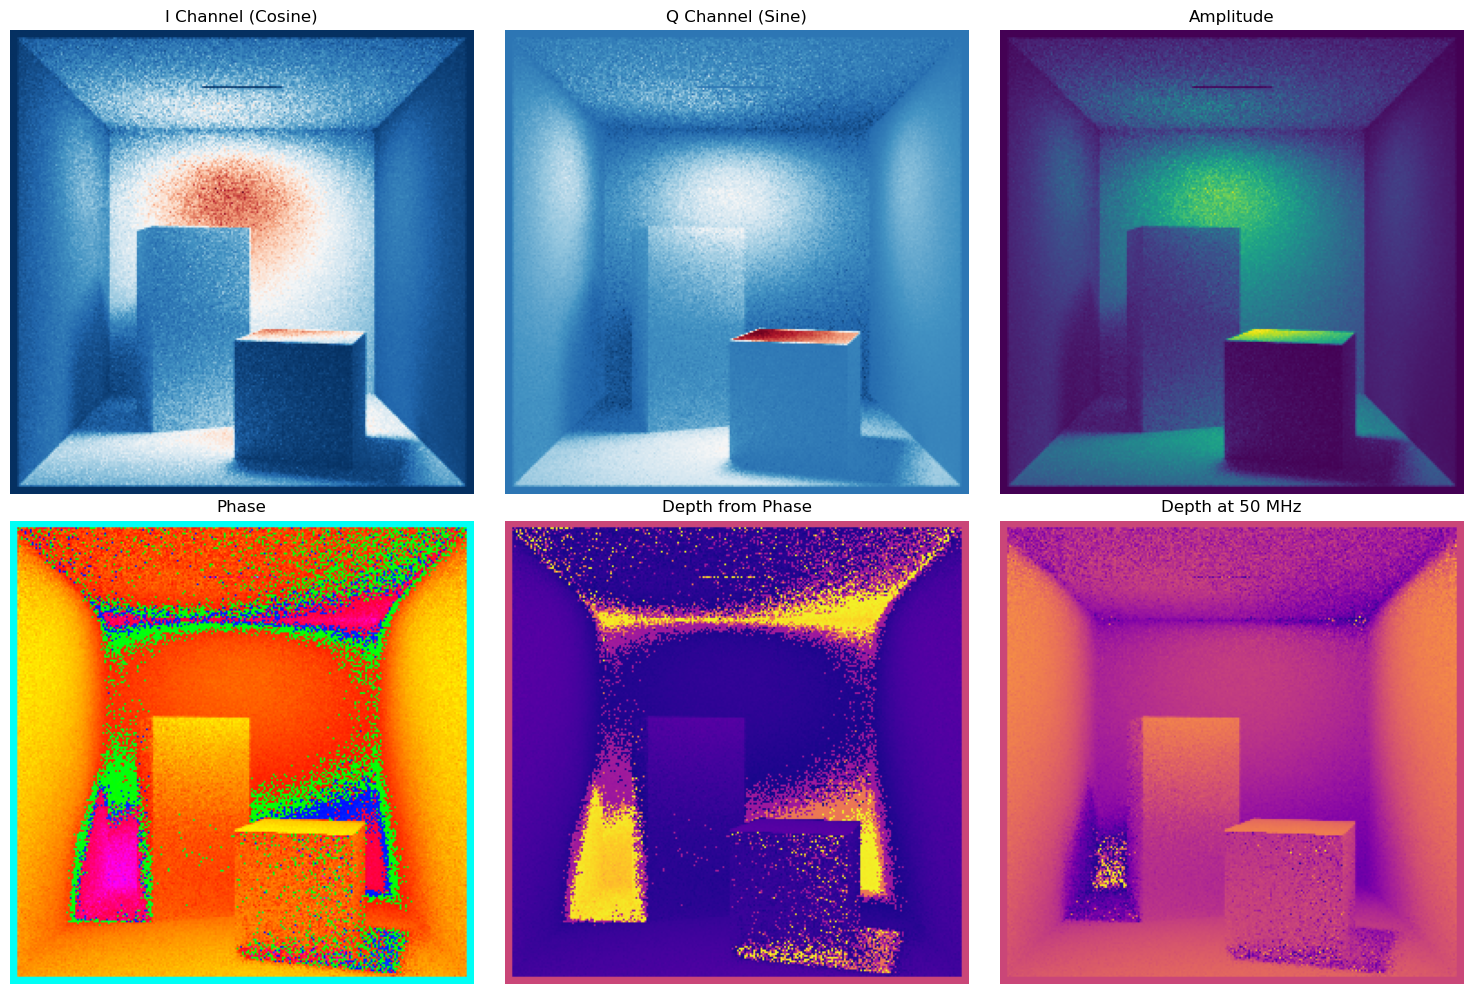

20 MHz unambiguous range: 7.49 m
50 MHz unambiguous range: 3.00 m


In [147]:
# Render AMCW phasor at 20 MHz
sensor = scene.sensors()[0]
I, Q, amplitude, phase, depth = render_amcw_phasor(scene, sensor, frequency_hz=20e6, spp=64)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# I channel (cosine correlation)
axes[0, 0].imshow(I.mean(axis=-1), cmap='RdBu')
axes[0, 0].set_title('I Channel (Cosine)')
axes[0, 0].axis('off')

# Q channel (sine correlation)
axes[0, 1].imshow(Q.mean(axis=-1), cmap='RdBu')
axes[0, 1].set_title('Q Channel (Sine)')
axes[0, 1].axis('off')

# Amplitude
axes[0, 2].imshow(amplitude.mean(axis=-1), cmap='viridis')
axes[0, 2].set_title('Amplitude')
axes[0, 2].axis('off')

# Phase
axes[1, 0].imshow(phase.mean(axis=-1), cmap='hsv', vmin=-np.pi, vmax=np.pi)
axes[1, 0].set_title('Phase')
axes[1, 0].axis('off')

# Depth (from phase)
axes[1, 1].imshow(depth.mean(axis=-1), cmap='plasma')
axes[1, 1].set_title('Depth from Phase')
axes[1, 1].axis('off')

# Compare with different frequency (higher resolution, shorter range)
I2, Q2, amp2, phase2, depth2 = render_amcw_phasor(scene, sensor, frequency_hz=50e6, spp=64)
axes[1, 2].imshow(depth2.mean(axis=-1), cmap='plasma')
axes[1, 2].set_title('Depth at 50 MHz')
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

# Print unambiguous ranges
print(f"20 MHz unambiguous range: {299792458 / (2 * 20e6):.2f} m")
print(f"50 MHz unambiguous range: {299792458 / (2 * 50e6):.2f} m")

### TransientHDRFilm

In [145]:
from __future__ import annotations  # Delayed parsing of type annotations
from typing import Optional, Tuple, List, Callable, Any

class TransientPathIntegrator(ADIntegrator):

    def __init__(self, props: mi.Properties):
        super().__init__(props) 
        self.pulse_samples = props.get("pulse_samples", 1)
        self.pulse = GaussianPulse(width_opl=props.get("pulse_width_opl", 0.03))

    def add_transient_f(self, film: TransientHDRFilm, pos: mi.Vector2f, ray_weight: mi.Float, sample_scale: mi.Float):
        """
        Return a lambda function for saving transient samples.
        It pre-multiplies the sample scale.
        """
        return (
            lambda spec, distance, wavelengths, active: film.add_transient_data(
                pos, distance, wavelengths, spec * sample_scale, ray_weight, active
            )
        )

    def prepare(self, scene, sensor, seed, spp, aovs):
        film = sensor.film()
        original_sampler = sensor.sampler()
        sampler = original_sampler.clone()

        if spp != 0:
            sampler.set_sample_count(spp)

        spp = sampler.sample_count()
        sampler.set_samples_per_wavefront(spp)

        film_size = film.crop_size()

        if film.sample_border():
            film_size += 2 * film.rfilter().border_size()

        wavefront_size = dr.prod(film_size) * spp
        film.prepare(aovs)

        sampler.seed(seed, wavefront_size)
        # Intentionally pass it on a list to mantain compatibility
        return [(sampler, spp)]

    def _add_pulse_samples(self,
                           sampler: mi.Sampler,
                           add_transient: Callable[[mi.Spectrum, mi.Float, mi.UnpolarizedSpectrum, mi.Mask], None],
                           Lr_dir: mi.Spectrum,
                           path_distance: mi.Float,
                           wavelengths: mi.UnpolarizedSpectrum,
                           active: mi.Bool):

        for _ in range(self.pulse_samples):
            # Sample time offset from pulse distribution; older pulse implementations
            # returned only the offset, newer ones may also provide an importance weight.
            pulse_time_offset = self.pulse.sample(sampler.next_1d())
            pulse_weight = self.pulse.eval(pulse_time_offset)

            # Weight contribution by pulse_weight / num_samples
            # For normalized pulses, pulse_weight = 1.0
            sample_weight = pulse_weight / self.pulse_samples

            add_transient(Lr_dir * sample_weight, path_distance + pulse_time_offset,
                          wavelengths, active)

    def render(self: mi.SamplingIntegrator,
               scene: mi.Scene,
               sensor: Union[int, mi.Sensor] = 0,
               seed: mi.UInt32 = 0,
               spp: int = 0) -> Tuple[mi.TensorXf, mi.TensorXf]:

        if isinstance(sensor, int):
            sensor = scene.sensors()[sensor]
        film = sensor.film()

        # Disable derivatives in all of the following
        with dr.suspend_grad():
            # Prepare the film and sample generator for rendering
            samplers_spps = self.prepare(
                scene=scene,
                sensor=sensor,
                seed=seed,
                spp=spp,
                aovs=self.aov_names()
            )

            # need to re-add in case the spp parameter was set to 0
            # (spp was set through the xml file)
            total_spp = 0
            for _, spp_i in samplers_spps:
                total_spp += spp_i

            for i, (sampler_i, spp_i) in enumerate(samplers_spps):
                # Generate a set of rays starting at the sensor
                ray, weight, pos = self.sample_rays(scene, sensor, sampler_i)

                # Launch the Monte Carlo sampling process in primal mode
                L, valid = self.sample(
                    scene=scene,
                    sampler=sampler_i,
                    ray=ray,
                    active=mi.Bool(True),
                    add_transient=self.add_transient_f(
                        film=film, pos=pos, ray_weight=weight, sample_scale=1.0 / total_spp
                    )
                )

                # Prepare an ImageBlock as specified by the film
                block = film.steady.create_block()

                # Only use the coalescing feature when rendering enough samples
                block.set_coalesce(block.coalesce() and spp_i >= 4)

                # NOTE(diego): Mitsuba 3.6.X needs extra care when dealing
                # with polarized functions, so we'll our version instead
                splat_function = (
                    ADIntegrator._splat_to_block
                )
                # Accumulate into the image block
                splat_function(
                    block, film, pos,
                    value=L * mi.Spectrum(weight),
                    weight=1.0,
                    alpha=dr.select(valid, mi.Float(1), mi.Float(0)),
                    aovs=[],
                    wavelengths=ray.wavelengths
                )

                # Explicitly delete any remaining unused variables
                del sampler_i, ray, weight, pos, L, valid

                # Perform the weight division and return an image tensor
                film.steady.put_block(block)

            steady_image, transient_image = film.develop()
            return steady_image, transient_image

    @dr.syntax
    def sample(self,
               scene: mi.Scene,
               sampler: mi.Sampler,
               ray: mi.Ray3f,
               active: mi.Bool,
               add_transient: Callable[[mi.Spectrum, mi.Float, mi.UnpolarizedSpectrum, mi.Mask], None],
               ) -> Tuple[mi.Spectrum, mi.Bool]:

        # Standard BSDF evaluation context for path tracing
        result = mi.Color3f(0.0)
        throughput = mi.Color3f(1.0)
        ray = mi.Ray3f(dr.detach(ray))
        active = mi.Bool(active)
        ctx = mi.BSDFContext()

        # Track total path length (optical path length) accounting for IOR
        path_length = mi.Float(0.0)
        depth = mi.UInt32(0)

        while dr.hint(active, max_iterations=self.max_depth, label="Transient"):
            # Ray intersection
            si = scene.ray_intersect(ray, active)
            active &= si.is_valid()

            # Accumulate path length with current index of refraction
            path_length[active] += si.t

            bsdf = si.bsdf()

            # Sample direct illumination from light sources (NEE)
            ds, emitter_weight = scene.sample_emitter_direction(
                si, sampler.next_2d(), True, active
            )

            active_light = active & (ds.pdf > 0)

            # Evaluate BSDF
            bsdf_val = bsdf.eval(ctx, si, si.to_local(ds.d), active_light)

            # Visibility test
            ray_shadow = si.spawn_ray_to(ds.p)
            visible = ~scene.ray_test(ray_shadow, active_light)

            # Compute contribution and add to transient film with pulse sampling
            active_contrib = active_light & visible
            
            # Compute distance and contribution (masking handles inactive lanes)
            distance_to_light = dr.norm(ds.p - si.p)
            total_opl = path_length + distance_to_light
            contribution = throughput * bsdf_val * emitter_weight
            
            # Use pulse sampling to properly integrate over the pulse shape
            # The active_contrib mask ensures only valid contributions are added
            self._add_pulse_samples(
                sampler, add_transient, contribution, 
                total_opl, ray.wavelengths, active_contrib
            )

            # Accumulate steady-state contribution
            result += contribution

            # Sample BSDF to get new direction
            bsdf_sample, bsdf_weight = bsdf.sample(
                ctx, si, sampler.next_1d(), sampler.next_2d(), active
            )

            active_bsdf = active & dr.any(bsdf_weight != 0)

            # Update throughput
            throughput *= bsdf_weight

            # Spawn new ray
            ray = si.spawn_ray(si.to_world(bsdf_sample.wo))

            # Update depth
            depth[si.is_valid()] += 1
            
            active = active_bsdf

        return (
            result,                    # Radiance
            (depth != 0),         # Ray validity flag for alpha blending
        )

Film type: <class 'mitransient.films.transient_hdr_film.TransientHDRFilm'>
Film size: [256, 256]
Temporal bins: 300
Start OPL: 3.5
Bin width OPL: 0.03

Steady image shape: (256, 256, 3)
Steady image stats: min=0.000000, max=0.568723, mean=0.073056
Transient data shape: (256, 256, 300, 3)
Transient data stats: min=0.000000, max=1.655422, mean=0.002241


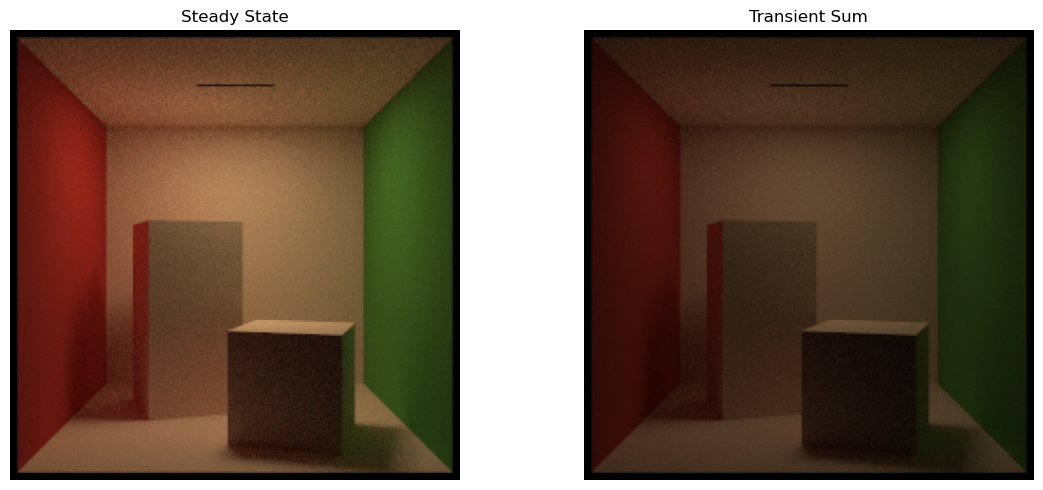

Video saved with 300 frames


In [146]:
integrator = TransientPathIntegrator(mi.Properties())
integrator.pulse = GaussianPulse(width_opl=0.03)

scene_dict = cornell_box()
scene_dict['sensor']['film']['bin_width_opl'] = 0.03
scene = mi.load_dict(scene_dict)
sensor = scene.sensors()[0]

# Debug: Check the film configuration
film = sensor.film()
print(f"Film type: {type(film)}")
print(f"Film size: {film.size()}")
if isinstance(film, TransientHDRFilm):
    print(f"Temporal bins: {film.temporal_bins}")
    print(f"Start OPL: {film.start_opl}")
    print(f"Bin width OPL: {film.bin_width_opl}")

steady_image, transient_data = integrator.render(scene, sensor, spp=128)

print(f"\nSteady image shape: {steady_image.shape}")
print(f"Steady image stats: min={np.min(steady_image):.6f}, max={np.max(steady_image):.6f}, mean={np.mean(steady_image):.6f}")
print(f"Transient data shape: {transient_data.shape}")
print(f"Transient data stats: min={np.min(transient_data):.6f}, max={np.max(transient_data):.6f}, mean={np.mean(transient_data):.6f}")

# Display steady state image
steady_image = np.array(steady_image) ** (1/2.2)

transient_sum = (np.sum(transient_data, axis=-2) * film.bin_width_opl) ** (1/2.2)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(steady_image)
plt.title('Steady State')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(transient_sum)
plt.title('Transient Sum')
plt.axis('off')
plt.tight_layout()
plt.show()

# Visualize transient video
# TransientHDRFilm returns shape: (height, width, temporal_bins, channels)
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('transient_path_output.mp4', fourcc, 30.0, (256, 256))
image_data = np.array(transient_data) ** (1/2.2) * 255

# Write frames (OpenCV uses BGR, so convert from RGB)
num_temporal_bins = image_data.shape[2]
for i in range(num_temporal_bins):
    # Extract frame at time bin i: (height, width, channels)
    frame = image_data[:, :, i, :]
    frame_bgr = cv2.cvtColor(frame.astype(np.uint8), cv2.COLOR_RGB2BGR)
    out.write(frame_bgr)

out.release()
print(f"Video saved with {num_temporal_bins} frames")


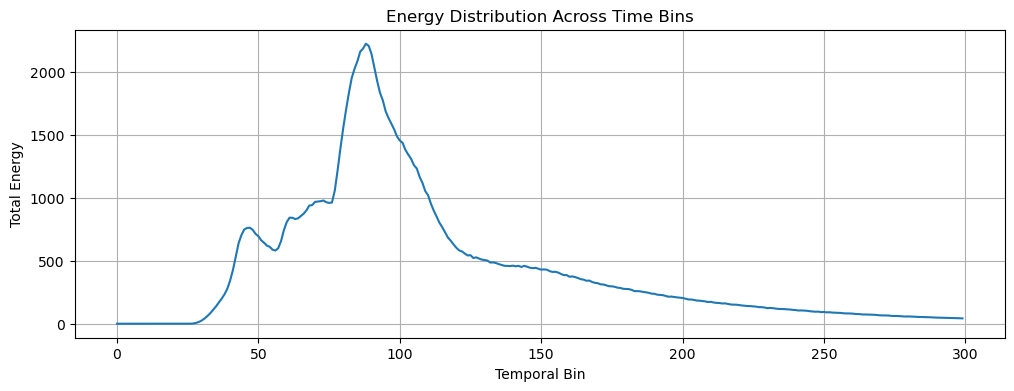

Peak energy at bin 88, OPL=5.260m, time=17.53ns


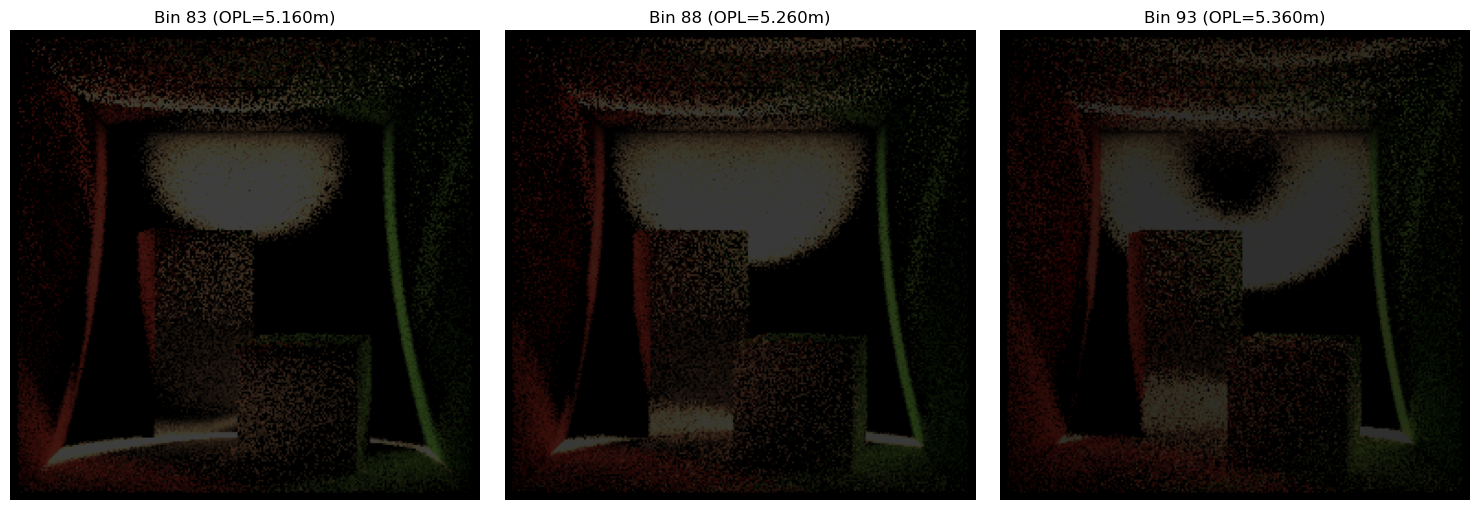


Transient integrated: min=0.000000, max=0.111308, mean=0.013448
Steady image: min=0.000000, max=0.773733, mean=0.249078
Ratio transient/steady max: 0.14x


In [144]:
# Analyze transient data distribution
# Convert to numpy first
transient_np = np.array(transient_data)
steady_np = np.array(steady_image)

temporal_sum = np.sum(transient_np, axis=(0, 1, 3))  # Sum over spatial and color dimensions
plt.figure(figsize=(12, 4))
plt.plot(temporal_sum)
plt.xlabel('Temporal Bin')
plt.ylabel('Total Energy')
plt.title('Energy Distribution Across Time Bins')
plt.grid(True)
plt.show()

# Find peak bin
peak_bin = np.argmax(temporal_sum)
peak_opl = 3.5 + peak_bin * 0.02
print(f"Peak energy at bin {peak_bin}, OPL={peak_opl:.3f}m, time={peak_opl/0.3:.2f}ns")

# Show a few frames around the peak
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, offset in enumerate([-5, 0, 5]):
    bin_idx = max(0, min(299, peak_bin + offset))
    frame = transient_np[:, :, bin_idx, :]  
    frame = np.clip(frame, 0, 100)  
    axes[i].imshow(np.clip(frame ** (1/2.2), 0, np.percentile(frame, 99.5)))
    axes[i].set_title(f'Bin {bin_idx} (OPL={3.5 + bin_idx*0.02:.3f}m)')
    axes[i].axis('off')
plt.tight_layout()
plt.show()

# Check steady vs transient sum
transient_integrated = np.sum(transient_np, axis=2) * 0.02  # Integrate over time
print(f"\nTransient integrated: min={np.min(transient_integrated):.6f}, max={np.max(transient_integrated):.6f}, mean={np.mean(transient_integrated):.6f}")
print(f"Steady image: min={np.min(steady_np):.6f}, max={np.max(steady_np):.6f}, mean={np.mean(steady_np):.6f}")
print(f"Ratio transient/steady max: {np.max(transient_integrated)/max(np.max(steady_np), 1e-10):.2f}x")
